## Overfitting, Underfitting and Model Selection

<big>

Now that we've gone over the basics of validation, and cross-validation, it's time to go into even more depth regarding model selection.

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more features?
- Add more training samples?

The answer is often counter-intuitive.  
- **Sometimes using a more complicated model will give _worse_ results.**
- **Sometimes adding training data will not improve your results.**

The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

# Illustration of the Bias-Variance Tradeoff
---

<big>

For this section, we'll work with a simple 1D regression problem.  
This will help us to easily visualize the data and the model, and the results generalize easily to  higher-dimensional datasets.  

We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

In [2]:
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [4]:
import numpy as np

def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

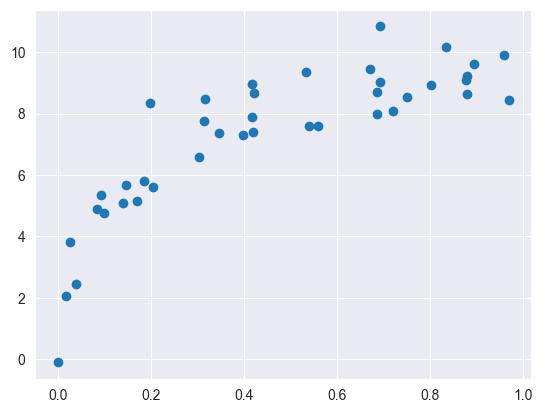

In [5]:
import matplotlib.pyplot as plt

X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

<big>

Now say we want to perform a regression on this data.  
Let's use the built-in linear regression function to compute a fit:

<br>

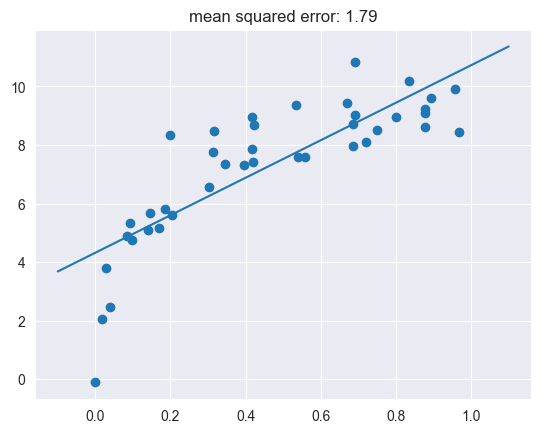

In [6]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

<big>

We have fit a straight line to the data, but clearly this model is not a good choice.  

> We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a **more complex** model.  
- We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs.
- Scikit-learn makes this easy with the ``PolynomialFeatures`` preprocessor, which can be pipelined with a linear regression.

Let's make a convenience routine to do this:

<br>

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

<big> Now we'll use this to fit a quadratic curve to the data.

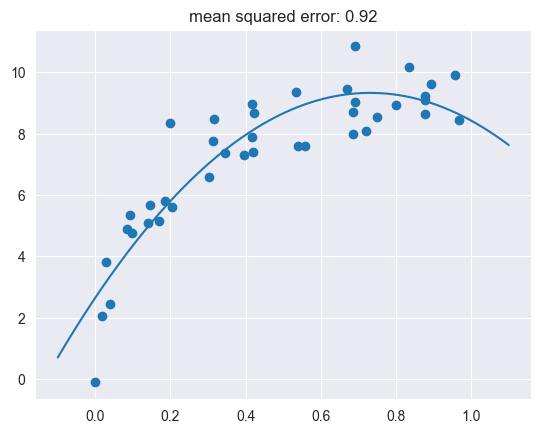

In [8]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

<big> This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

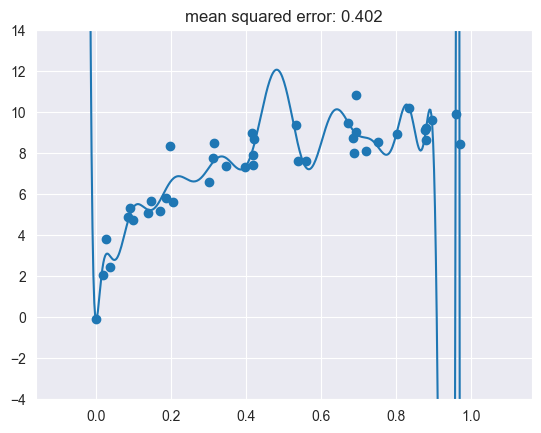

In [9]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

<big> 

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

Just for fun, let's a widget to explore this interactively:

In [10]:
from ipywidgets.widgets import interact, IntSlider

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_test = model.predict(X_test)

    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.ylim(-4, 14)
    plt.title("mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    
interact(plot_fit, degree=IntSlider(value=2, min=1, max=10), Npts=[40, 80, 160]);

interactive(children=(IntSlider(value=2, description='degree', max=10, min=1), Dropdown(description='Npts', op…

<br>

# Detecting Over-fitting with Validation Curves
---


```python
validation_curve(estimator, X, y, param_name, param_range, cv=None, scoring=None, n_jobs=1)
```


<big> 

- Clearly, computing the error on the training data is not enough (we saw this previously).
- As above, we can use **cross-validation** to get a better handle on how the model fit is working.
- Let's do this here, again using the ``validation_curve`` utility. To make things more clear, we'll use a slightly larger dataset:


In [11]:
from sklearn.model_selection import learning_curve, validation_curve

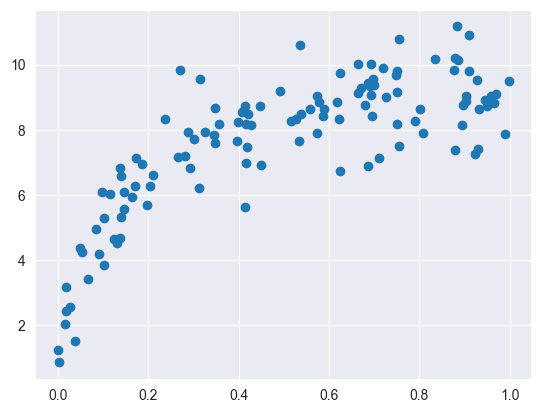

In [12]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [13]:
import numpy as np

In [14]:
def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(1, 12)

val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       param_name='polynomialfeatures__degree', 
                                       param_range=degree, 
                                       cv=5,
                                       scoring=rms_error)

Now let's plot the validation curves:

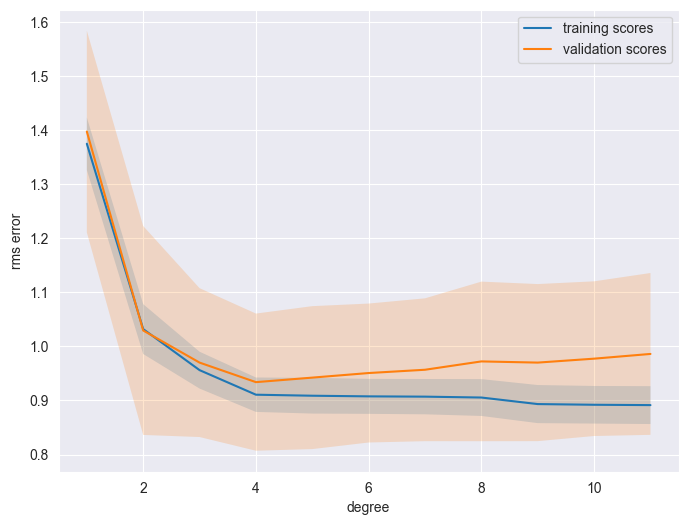

In [15]:
plt.figure(figsize=(8, 6))

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

<big>

Notice the trend here, which is common for this type of plot.

1. **For a small model complexity**, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. **As the model complexity grows**, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the **training score (nearly) always improves with model complexity**. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

Here's our best-fit model according to the cross-validation:

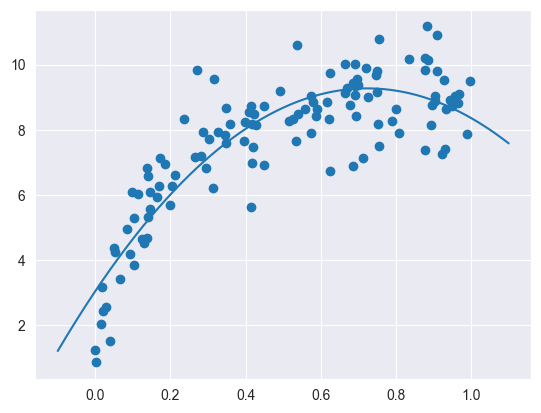

In [17]:
model = PolynomialRegression(2).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

---
> # 2. Detecting Data Sufficiency with Learning Curves

---

```
Signature: learning_curve(estimator, X, y, train_sizes, cv=None, scoring=None)

Determines cross-validated training and test scores for different training
set sizes.

A cross-validation generator splits the whole dataset k times in training
and test data. Subsets of the training set with varying sizes will be used
to train the estimator and a score for each training subset size and the
test set will be computed. Afterwards, the scores will be averaged over
all k runs for each training subset size.
```

<big>

As you might guess, the exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.  Here we'll illustrate the use of *learning curves*, which display this property.

The idea is to plot the mean-squared-error for the training and test set as a function of *Number of Training Points*

In [18]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=4):
    plt.figure(figsize=(8, 5))
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, 
                                                  train_sizes=train_sizes, 
                                                  cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

Let's see what the learning curves look like for a linear model:

In [19]:
interact(plot_learning_curve, 
         degree=IntSlider(value=4, min=1, max=10))

interactive(children=(IntSlider(value=4, description='degree', max=10, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_learning_curve(degree=4)>

<big> 
    
- This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**.  Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.

- As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?)

- It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will *never* get you there.  For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0!

What if we get even more complex?

For an even more complex model, we still converge, but the convergence only happens for *large* amounts of training data.

So we see the following:

- you can **cause the lines to converge** by adding more points or by simplifying the model.
- you can **bring the convergence error down** only by increasing the complexity of the model.

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data.

To make this more concrete, imagine some telescope data in which the results are not robust enough.  You must think about whether to spend your valuable telescope time observing *more objects* to get a larger training set, or *more attributes of each object* in order to improve the model.  The answer to this question has real consequences, and can be addressed using these metrics.

## Summary

<big>

We've gone over several useful tools for model validation

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness
- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.
- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:
  + when the two curves are close, it indicates *underfitting*
  + when the two curves are separated, it indicates *overfitting*
  + the "sweet spot" is in the middle
- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training samples**
  + when the curves are close, it indicates *underfitting*, and adding more data will not generally improve the estimator.
  + when the curves are far apart, it indicates *overfitting*, and adding more data may increase the effectiveness of the model.
  
These tools are powerful means of evaluating your model on your data.